# Simulation of indirect reciprocity on graphs

### Final Project for Math 243,  Spring 2015 

### Professor Martin Nowak

### Harvard University

# Abstract

We consider a model of indirect reciprocity on graphs with a prisoner's dilemma game being played between nodes. Indirect reciprocity is encoded by establishing a probability for each node to know the strategy of its neighbor. This probability of "correct" gossip may depend on the local graph structure. We find that under reasonable assumptions, the introduction of this information flow increases the stability and payoff of cooperative strategies competing with defectors. Moreover, this effect is pronounced in graphs resembling realistic social networks, such as small-world networks and scale-free networks. Finally, we find that the introduction of gossip causes neighbors and connectivity to positively influence the payoff of cooperators. This stands in contrast to the opposite result for direct cooperation, where the number of neighbors should be minimal to favor cooperation. This new result is more in line with the intuition that more complex and connected social networks should support cooperation.

# Introduction

We imagine a social network as represented on an undirected graph $G = (V,E)$. We consider for simplicity only two strategies: defectors, and clever cooperators. Defectors always defect. Clever cooperators cooperate always unless they know their partner to be a defector.

The payoff matrix is given as follows for states $C,D$

$$P = \begin{pmatrix} b - c & -c \\ b & 0\end{pmatrix}$$

With states $C,D,C_k$ (cooperate, defect, cooperate and know), we get the following payoff matrix:

$$P = \begin{pmatrix} b - c & -c & b-c \\ b & 0 & 0 \\ b - c& 0 & b - c\end{pmatrix}$$

In [1]:
%pylab inline
b = 2
c = 0.5
payoffs = np.array([[b - c, -c,b-c],[b,0,0],[b-c,0,b-c]])

cooperate = 0
defect = 1
cooperate_and_know = 2

Populating the interactive namespace from numpy and matplotlib


On the graph $G$, imagine an indirect reciprocity scenario with gossip. In particular, there is a probability $p(i,j,G)$ which depends on the identity of the two nodes in question and on the graph that node $i$ learns the identity of node $j$. One might imagine this as the probability that the gossip about node $j$ reaches node $i$ _and_ is correct.

This is the code for most of the functions that we use in this simulation:

In [1]:
from graph_reciprocity import *

In [3]:
cooperate = 0
defect = 1
cooperate_and_know = 2

def get_payoff(player_strategy,opponent_strategy,payoffs):
    return payoffs[player_strategy,opponent_strategy]

def draw_graph(G):
    node_color = [0 if G.node[i]['strategy'] == cooperate else 0.1 for i in range(len(G.nodes()))]
    node_label = {i:G.node[i]['score'] for i in range(len(G.nodes()))}
    nx.draw(G,node_color=node_color,labels=node_label,cmap='spring')

def zero_scores(G):
    for n in G.nodes():
        G.node[n]['score'] = 0.0

def update_score(G,payoffs,prob_of_known_fn = lambda x,y: 1.0):
    for e in G.edges():
        update_score_on_edge(e,G,prob_of_known_fn,payoffs)

def update_score_on_edge(e,G,prob_of_known_fn,payoffs = np.array([[b - c, -c,b-c],[b,0,0],[b-c,0,b-c]])):
    
    s0 = G.node[e[0]]['strategy']
    s1 = G.node[e[1]]['strategy']
    
    #if the identity of opponent is known, change to state 2
    p_known = prob_of_known_fn(e,G)
    known = np.random.binomial(1,p_known)
    if s0 == cooperate and known:
        s0 = cooperate_and_know

    p_known = prob_of_known_fn(e[::-1],G)
    known = np.random.binomial(1,p_known)
    if s1 == cooperate and known:
        s1 = cooperate_and_know

    G.node[e[0]]['score'] += payoffs[s0,s1]
    G.node[e[1]]['score'] += payoffs[s1,s0]
    



        
def get_average_scores(G):
    #get the average scores for cooperators and defectors
    strategy_names = ['cooperate','defect']
    scores = np.zeros(2)
    num_nodes = np.zeros(2)
    for i in G.nodes():
        scores[G.node[i]['strategy']] += G.node[i]['score']
        num_nodes[G.node[i]['strategy']] += 1
    return scores/num_nodes

def create_graph(N_nodes,p_edge,p_coop,random_number=True):
    #Random graph
    #p_coop is the fraction of cooperators
    G = nx.gnp_random_graph(N_nodes,p_edge,directed=False)
    return set_graph_strategies(G, N_nodes,p_coop,random_number)
    
def set_graph_strategies(G, N_nodes,p_coop,random_number=True):
    if random_number:
        for n in G.nodes():
            G.node[n]['strategy'] = np.random.binomial(1,1-p_coop)
            G.node[n]['score'] = 0
    else:
        nodes = G.nodes()
        random.shuffle(nodes)
        for i,n in enumerate(nodes):
            if i >= int(round(p_coop*N_nodes)):
                G.node[n]['strategy'] = 1
            else:
                G.node[n]['strategy'] = 0
            G.node[n]['score'] = 0
    return G


def expected_return_c(b,c,p_coop,p_edge,N_nodes,p_know):
    return (p_coop*(b-c) + (1 - p_coop)*(1-p_know)*(-c))*N_nodes*p_edge

def expected_return_d(b,c,p_coop,p_edge,N_nodes,p_know):
    return (p_coop*(1-p_know)*b)*N_nodes*p_edge

def get_p_known(e,G,p):
    num_mutual_friends =len(set(G.neighbors(e[0])) & set(G.neighbors(e[1])))
    return 1 - (1-p)*(1- p**2)**num_mutual_friends

def get_p_known_direct(e,G,p):
    return p


def create_small_world_graph(N_nodes,p_edge,p_coop,random_number=True):
    n = N_nodes
    k = int(p_edge*N_nodes)
    p = 0.5
    #Random graph
    #p_coop is the fraction of cooperators
    G = nx.watts_strogatz_graph(n,k,p)
    return set_graph_strategies(G, N_nodes,p_coop,random_number)

def create_scale_free_graph(N_nodes,p_edge,p_coop,random_number=True):
    #scale free and small world
    #Growing Scale-Free Networks with Tunable Clustering
    n = N_nodes
    m = int(0.5*p_edge*N_nodes)
    p = 1.0
    #Random graph
    #p_coop is the fraction of cooperators
    G = nx.powerlaw_cluster_graph(n,m,p)
    return set_graph_strategies(G, N_nodes,p_coop,random_number)

def get_average_scores_for_graph_type(N_nodes,p_edge,p_coop,p,num_trials,graph_fn,random_number=True):
    coop_score = 0
    def_score = 0
    for j in range(num_trials):
        G = graph_fn(N_nodes,p_edge,p_coop,random_number)
        update_score(G,payoffs,lambda x,y: get_p_known(x,y,p))
        scores = get_average_scores(G)
        coop_score += scores[0]
        def_score += scores[1]
    coop_score /= num_trials
    def_score /= num_trials
    return coop_score,def_score

def get_average_nash_scores_for_graph_type(N_nodes,p_edge,p_coop,p,num_trials,graph_fn,random_number=True,strategy = defect):
    score = 0.0
    num_edges = 0.0
    for j in range(num_trials):
        G = graph_fn(N_nodes,p_edge,p_coop,random_number)
        score += get_average_nash_score(G,payoffs,lambda x,y: get_p_known(x,y,p),strategy)
        num_edges += len(G.edges())
    score /= num_trials
    num_edges /= num_trials
    return score,num_edges


#This is the expected score per edge (i.e per neighbor of a given node).
def get_average_nash_score(G,payoffs,prob_of_known_fn,strategy = defect):
    score = 0
    for n in G.nodes():
        if strategy == defect:
            score += get_score_for_single_defector_node(n,G,payoffs,prob_of_known_fn)
        else:
            score += get_score_for_single_cooperator_node(n,G,payoffs,prob_of_known_fn)
    if len(G.nodes()) == 0:
        return 0.0
    return 0.5*score/len(G.edges())

def get_score_for_single_defector_node(n,G,payoffs = np.array([[b - c, -c,b-c],[b,0,0],[b-c,0,b-c]]),prob_of_known_fn = lambda x,y: 1.0):
    score = 0
    edges = G.edges([n])
    for e in edges:
        p_known = prob_of_known_fn(e[::-1],G)
        score += payoffs[defect,cooperate_and_know]*p_known + payoffs[defect,cooperate]*(1 - p_known)
    return score

def get_score_for_single_cooperator_node(n,G,payoffs = np.array([[b - c, -c,b-c],[b,0,0],[b-c,0,b-c]]),prob_of_known_fn = lambda x,y: 1.0):    
    score = 0
    edges = G.edges([n])
    for e in edges:
        p_known = prob_of_known_fn(e,G)
        score += payoffs[cooperate_and_know,defect]*p_known + payoffs[cooperate,defect]*(1 - p_known)
    return score

def get_average_mutual_neighbors_for_graph_type(N_nodes,p_edge,p,num_trials,create_graph_fn,random_number=True):
    p_known, p_known_curr, mutual_neighbors, mutual_neighbors_curr,num_edges = 0.0,0.0,0.0,0.0,0.0
    for i in range(num_trials):
        G = create_graph_fn(N_nodes,p_edge,p_coop,random_number)
        print len(G.nodes()), len(G.edges())
        p_known_curr,mutual_neighbors_curr = get_average_p_known(G,prob_of_known_fn = lambda x,y: get_p_known(x,y,p))
        p_known += p_known_curr
        mutual_neighbors += mutual_neighbors_curr
        num_edges += len(G.edges())
    num_edges /= num_trials
    p_known /= num_trials
    mutual_neighbors /= num_trials
    return p_known,mutual_neighbors,num_edges

#This is the expected score per neighbor of a given node.
def get_average_p_known(G,prob_of_known_fn= lambda x,y: 1.0):
    p_known, p_known_curr, mutual_neighbors, mutual_neighbors_curr = 0.0,0.0,0.0,0.0
    for n in G.nodes():
        p_known_curr,mutual_neighbors_curr = add_p_known_for_single_node(G,n,prob_of_known_fn)    
        p_known += p_known_curr
        mutual_neighbors += mutual_neighbors_curr
    p_known /= 2*len(G.edges())
    mutual_neighbors /= 2*len(G.edges())
    return p_known,mutual_neighbors
        
        
def add_p_known_for_single_node(G,n,prob_of_known_fn):
    p_known, p_known_curr, mutual_neighbors, mutual_neighbors_curr = 0.0,0.0,0.0,0.0
    edges = G.edges([n])
    if len(edges) == 0:
        print 'no neighbors'
        return 1.0,0.0
    for e in edges:
        p_known += prob_of_known_fn(e[::-1],G)
        mutual_neighbors += len(set(G.neighbors(e[0])) & set(G.neighbors(e[1])))
#     p_known /= len(edges)
#     mutual_neighbors /= len(edges)
    return p_known,mutual_neighbors

def update_threshold(G,prob_of_known_fn = lambda x,y: 1.0):
    for n in G.nodes():
        num_edges = len(G.edges([n]))
        if len(G.edges([n])) > 0:
            p_known = add_p_known_for_single_node(G,n,prob_of_known_fn)[0]/len(G.edges([n]))
        else:
            p_known = 0
        G.node[n]['threshold'] = 1.0/p_known if p_known > 0 else 1.0


# A constant probability of gossip

As a first case, let us assume that the value $p_{known}(i,j,G) = p_{known}$ is a constant. In this case, the new game represents essentially a transformation of the payoff matrix regarding expected returns.

We can compute the expected scores for cooperators and defectors as follows. Given a random graph, we expect on average $N p_{edge}$ neighbors, where $p_{edge}$ is the probability that a given edge exists. Now, for each of these neighbors, we have a fraction $p_{coop}$ of cooperators and the rest defectors. The payoff of encountering a defector ($-c$) is only realized when the identity of the defector is not known. This leads us to the following:
$$E[score|C,p_{known}] = N p_{edge} \left(p_{coop} (b - c) + (1 - p_{coop}) (1 - p_{known}) (-c)\right)$$
Similar reasoning gives:
$$E[score|D,p_{known}] = N p_{edge} p_{coop}(1- p_{known}) b$$

Setting these equal, we find the condition for stability between cooperative and defective strategies:

$$p_{coop} = \frac{ c (1 - p_{known})}{(b-c) p_{known}}$$

or equivalently

$$p_{known} = \frac{1}{1 + p_{coop} \left(\frac{b-c}{c}\right) }$$

.Now let's create several graphs and compute the scores for different values of $p_{known}$, the probability that the identity of a neighbor is known.

In [10]:
p_coop = 0.2
N_nodes = 1000
p_edge = 10.0/N_nodes
p_range = np.linspace(0,1,num=10,endpoint=True)

In [ ]:
coop_score_range = zeros_like(p_range)
def_score_range = zeros_like(p_range)
for i,p in enumerate(p_range):
    G = create_graph(N_nodes,p_edge,p_coop)
    update_score(G,payoffs,lambda x,y: p)
    scores = get_average_scores(G)
    coop_score_range[i] = scores[0]
    def_score_range[i] = scores[1]

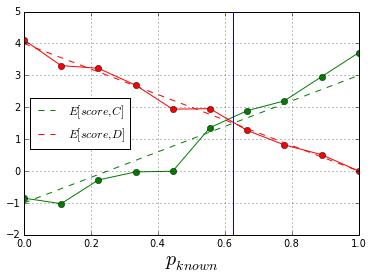

In [266]:
plot(p_range,coop_score_range,'-og')
plot(p_range,def_score_range,'-or')
plot(p_range,expected_return_c(b,c,p_coop,p_edge,N_nodes,p_range),'--g',label=r'$E[score,C]$')
plot(p_range,expected_return_d(b,c,p_coop,p_edge,N_nodes,p_range),'--r',label=r'$E[score,D]$')
xlabel(r'$p_{known}$',size=20)
ylabel(r'$score$',size=20)
grid()
axvline(1/(1 + p_coop*(b-c)/c))
legend(loc = 'center left')

Here we have plotted the the expected scores (both theoretical predictions and simulation results) for both defectors and cooperators. The red line represents the expected score for cooperators and the green line for defectors. The dashed lines are the theoretical predictions while the connected circles represent the simulation results. The blue line gives the theoretical prediction for the "breakeven point" when cooperators and defectors have the same payoff. We find that the expected return for cooperators increases as the gossip becomes better. This makes intuitive sense -- from a cooperators perspective, as the probability of knowing who is a defector increases, the exploitation by these defectors decreases.

We could also plot the expected returns as a function of the fraction of cooperators $p_{coop}$. For similar reasons, we find of course that the more cooperators there are, the more beneficial it is to be a cooperator.

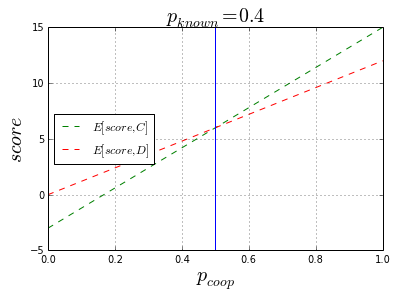

In [20]:
p_k = 0.4
plot(p_range,expected_return_c(b,c,p_range,p_edge,N_nodes,p_k),'--g',label=r'$E[score,C]$')
plot(p_range,expected_return_d(b,c,p_range,p_edge,N_nodes,p_k),'--r',label=r'$E[score,D]$')
xlabel(r'$p_{coop}$',size=20)
ylabel(r'$score$',size=20)
grid()
axvline(c/(b-c)*(1-p_k)/p_k)
legend(loc = 'center left')
title(r'$p_{known} = ' + str(p_k) + '$',size=20)

# Structure dependent gossip

Now we can let $p_{known}$ be a function of the graph structure itself. The intuition is that observations are made and gossip is transmitted throughout the social network. Therefore the probability of a correct transmission of information should depend on the local structure of the social network. One example dependence could be
$$p_{known}(e,G) = \frac{\text{numMutualNeighbors}(e_0,e_1)}{N_{nodes}}$$
We might also assume that gossip spreads probabilistically across the edges. In particular, assume every edge on the graph transmits gossip correctly with a probability $p$. The probability that a node "knows" another nodes reputation is given by the edge percolation probability between these two nodes on the graph. In our case we are only interested in sets of two nodes that are neighbors on the graph. This is a consequence of the fact that the "game graph" (i.e. who plays with whom) is the same as the "social graph" (i.e. who interacts with whom/who knows whom). This is a reasonable assumption, but one might also extend the problem to considering separate graphs for these two cases.

Since the nodes in question are neighbors, the most likely (lowest order in $p$) contribution comes from knowing the neighbor directly. The next order is given by the transmission of information across neighbors (i.e. paths of length $2$), and so on. We can thus expand the percolation probability in the lowest orders and only consider the shortest paths (e.g. lengths $1$ and $2$) in our calculation. This also represents a reasonable assumption that gossip that has been transmitted across several nodes loses its value to be further transmitted, which reduces the weight of the longer paths in the computation of the probability even further. To lowest (zeroth) order we thus have
$$p_{known}(e,G) = 1 - (1-p) = p$$
and to first order 
$$p_{known}(e,G) = 1 - (1-p)(1-p^2)^{\text{numMutualNeighbors}(e_0,e_1)}$$
where $e$ denotes an ordered edge in the graph $G$ with start node $e_0$ and end node $e_1$. The chances that the information arrives is given by $1 - $ the probability that all transmissions fail. In the second formula, for example, this is the case when the transmission fails across the direct neighbor edge _and_ across all paths of length $2$. Note also that the lowest order approximation is equivalent to a constant $p_{known}$ throughout the graph, a case we discussed above. Moreover, this can be regarded as a purely direct reciprocity approach. We play with an individual, and with probability $p$ we have played with him before and accurately remember his strategy. The second equation actually involves gossip, referring to the flow of information across the network beyond just direct observation.



## Erdos-Renyi Random Graph

Let us now create several graphs and measure computationally the expected return for cooperators and defectors.

In [30]:
p_coop = 0.5
N_nodes = 1000
p_edge = 1.0*100/N_nodes
p_range = np.linspace(0,1,num=10,endpoint=True)
coop_score_range1 = zeros_like(p_range)
def_score_range1 = zeros_like(p_range)
coop_score_range2 = zeros_like(p_range)
def_score_range2 = zeros_like(p_range)
for i,p in enumerate(p_range):
    G = create_graph(N_nodes,p_edge,p_coop)
    update_score(G,payoffs,lambda x,y: get_p_known_direct(x,y,p))
    scores = get_average_scores(G)
    coop_score_range1[i] = scores[0]
    def_score_range1[i] = scores[1]
    
    G = create_graph(N_nodes,p_edge,p_coop)
    update_score(G,payoffs,lambda x,y: get_p_known(x,y,p))
    scores = get_average_scores(G)
    coop_score_range2[i] = scores[0]
    def_score_range2[i] = scores[1]

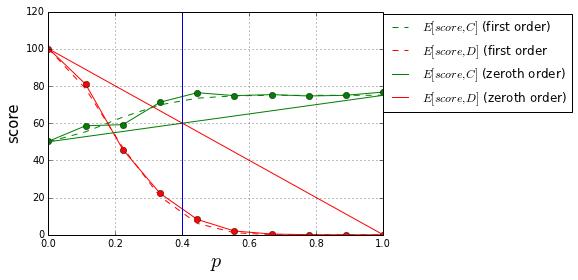

In [45]:
plot(p_range,coop_score_range2,'-og')
plot(p_range,def_score_range2,'-or')
plot(p_range,expected_return_c(b,c,p_coop,p_edge,N_nodes,1-(1-p_range)*(1-p_range**2)**(p_edge**2*N_nodes)),'--g',label=r'$E[score,C]$ (first order)')
plot(p_range,expected_return_d(b,c,p_coop,p_edge,N_nodes,1-(1-p_range)*(1-p_range**2)**(p_edge**2*N_nodes)),'--r',label=r'$E[score,D]$ (first order')
plot(p_range,expected_return_c(b,c,p_coop,p_edge,N_nodes,p_range),'-g',label=r'$E[score,C]$ (zeroth order)')
plot(p_range,expected_return_d(b,c,p_coop,p_edge,N_nodes,p_range),'-r',label=r'$E[score,D]$ (zeroth order)')
xlabel(r'$p$',size=20)
ylabel(r'score',size=15)
grid()
axvline(1/(1 + p_coop*(b-c)/c))
legend(loc = (1,0.55))

Above we try the case with the function
$$p_{known}(e,G) = 1 - (1-p)(1-p^2)^{\text{numMutualNeighbors}(e_0,e_1)}$$
For an Erdos-Renyi, random graph like we have, we can approximate
$$p_{known}(e,G) = E[1 - (1-p)(1-p^2)^{\text{numMutualNeighbors}(e_0,e_1)}] \approx 1 - (1-p)(1-p)^{E[\text{numMutualNeighbors}(e_0,e_1)]}$$
where
$$E[\text{numMutualNeighbors}(e_0,e_1)] \approx p_{edge}^2N_{nodes}$$
And thus, we get
$$p_{known}(e,G) \approx 1 - (1-p)(1-p^2)^{p_{edge}^2N_{nodes}}$$
which we can then plug into our formulas for $E[score,C/D,p_{known}]$.
This theoretical prediction is plotted in the above plot and agrees well with the computational results. We show also the zeroth order approximation where only direct reciprocity is considered. We find that gossip, even to its lowest approximation, significantly improves the score of cooperators and reduces the score of defectors dramatically.


## Small World Graph and Scale Free Graph

Now let us try out the same thing for different types of graphs. We expect that the structure of the graphs will have an impact on the relative payoffs for cooperators and defectors, since they affect how well the gossip spreads throughout the network.

In [69]:


num_trials = 10
p_coop = 0.3
N_nodes = 100
p_edge = 1.0*10/N_nodes
p_range = np.linspace(0,1,num=10,endpoint=True)
p_know_range = 1-(1-p_range)*(1-p_range**2)**(p_edge**2*N_nodes)
coop_score_range = zeros_like(p_range)
def_score_range = zeros_like(p_range)
coop_score_range_sw = zeros_like(p_range)
def_score_range_sw = zeros_like(p_range)
coop_score_range_sf = zeros_like(p_range)
def_score_range_sf = zeros_like(p_range)
for i,p in enumerate(p_range):
    coop_score_range[i],def_score_range[i] = get_average_scores_for_graph_type(N_nodes,p_edge,p_coop,p,num_trials,create_graph,random_number=False)
    coop_score_range_sw[i],def_score_range_sw[i] = get_average_scores_for_graph_type(N_nodes,p_edge,p_coop,p,num_trials,create_small_world_graph,random_number=False)
    coop_score_range_sf[i],def_score_range_sf[i] = get_average_scores_for_graph_type(N_nodes,p_edge,p_coop,p,num_trials,create_scale_free_graph,random_number=False)

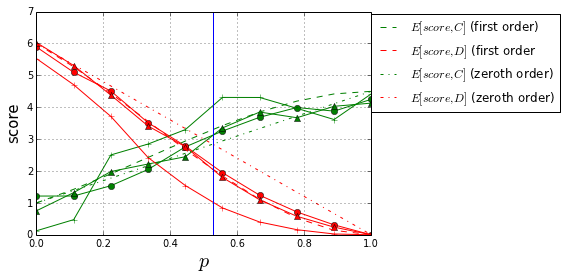

In [70]:
p_know_range = 1-(1-p_range)*(1-p_range**2)**(p_edge**2*N_nodes)
plot(p_range,coop_score_range,'-og')
plot(p_range,def_score_range,'-or')
plot(p_range,coop_score_range_sw,'-^g')
plot(p_range,def_score_range_sw,'-^r')
plot(p_range,coop_score_range_sf,'-+g')
plot(p_range,def_score_range_sf,'-+r')
plot(p_range,expected_return_c(b,c,p_coop,p_edge,N_nodes,p_know_range),'--g',label=r'$E[score,C]$ (first order)')
plot(p_range,expected_return_d(b,c,p_coop,p_edge,N_nodes,p_know_range),'--r',label=r'$E[score,D]$ (first order')
plot(p_range,expected_return_c(b,c,p_coop,p_edge,N_nodes,p_range),'-.g',label=r'$E[score,C]$ (zeroth order)')
plot(p_range,expected_return_d(b,c,p_coop,p_edge,N_nodes,p_range),'-.r',label=r'$E[score,D]$ (zeroth order)')
xlabel(r'$p$',size=20)
ylabel(r'score',size=15)
grid()
axvline(1/(1 + p_coop*(b-c)/c))
legend(loc = (1,0.55))

Here again, we plot the scores for cooperators and defectors as a function of the parameter $p$. In particular, the dash-dotted line gives the theoretical payoffs without gossip (zeroth order). The dashed lines give the approximate theoretical prediction for the payoffs with first order gossip (i.e. gossip flowing only across common neighbors). The solid lines with circles, triangles, and pluses respectively represent Erdos-Renyi, Small-World, and Scale Free random graphs, respectively, with first order gossip.

We find that for small world networks and in particular for highly-clustered small world, scale free networks, cooperation is strongly favored. This is because gossip can spread more easily on these graphs since nodes tend to be more clustered and have more common neighbors. The gossip allows the cooperators to obviate exploitation by the defectors and costs defectors much of their payoff. This shifts the intersection point where $E[score|D] = E[score|C]$ significantly.

In summary, we find that including the effect of gossip significantly supports and stabilizes cooperative strategies. Moreover, scale-free and small-world networks -- highly clustered graphs that are known to approximate social networks well  -- have a particularly strong effect stabilizing cooperation.

## Nash Equilibrium Condition for All-C

Finally, let us examine the stability of the situation where all strategies are cooperative. To this end, we consider the expected payoff on a graph where all nodes play $C$ and compare it to the expected payoff of a single defector on a graph where everybody else plays $C$.

In this situation, we have
$$E[score|D,i,G] = \sum_{j \in N(i)} (1 - p_{know}(i,j,G)) b$$
where $N(i)$ is the set of direct neighbors of node $i$ (our single defector). Compare this to the expected payoff for a cooperator among all cooperators:
$$E[score|C,i,G] = \sum_{j \in N(i)} (b - c) = N(i) (b - c)$$
Comparing the two gives
\begin{eqnarray}
\sum_{j \in N(i)} (1 - p_{know}(i,j,G)) b \approx N(i) (1 - p_{know}(i,j,G)) = N(i) (b-c)\\
\end{eqnarray}
Whence
$$\frac{c}{b} < p_{know}(i,j,G)$$
Assuming that the expectation carries through linearly as we average over all graphs $G$:
$$\frac{c}{b} < p_{know}$$
The above condition is the strict Nash equilibrium condition for the $C$ strategy. This condition is exact for a regular graph where $p_{know}$ is the same for every node. For other graphs, the results will vary because the expectation does not carry through linearly anymore (in particular, $p_{know}(i,j,G)$ is a nonlinear function of the local graph structure and thus its expectation over all graph instances will be complicated).

To examine this condition numerically, we again simulate our game on several graphs and compute $E[score|D]$ in the limit of $p_{coop} \to 1$.

In [82]:
num_trials = 10
p_coop = 1 - 1.0/N_nodes #0.995
N_nodes = 400 #4000
p_edge = 1.0*40/N_nodes #100/N_nodes
p_range = np.linspace(0,1,num=10,endpoint=True)
p_know_range = 1-(1-p_range)*(1-p_range**2)**(p_edge**2*N_nodes)
coop_score_range = zeros_like(p_range)
def_score_range = zeros_like(p_range)
coop_score_range_sw = zeros_like(p_range)
def_score_range_sw = zeros_like(p_range)
coop_score_range_sf = zeros_like(p_range)
def_score_range_sf = zeros_like(p_range)
for i,p in enumerate(p_range):
    def_score_range[i] = get_average_nash_scores_for_graph_type(N_nodes,p_edge,p_coop,p,num_trials,create_graph,random_number=False)
    def_score_range_sw[i] = get_average_nash_scores_for_graph_type(N_nodes,p_edge,p_coop,p,num_trials,create_small_world_graph,random_number=False)
    def_score_range_sf[i] = get_average_nash_scores_for_graph_type(N_nodes,p_edge,p_coop,p,num_trials,create_scale_free_graph,random_number=False)

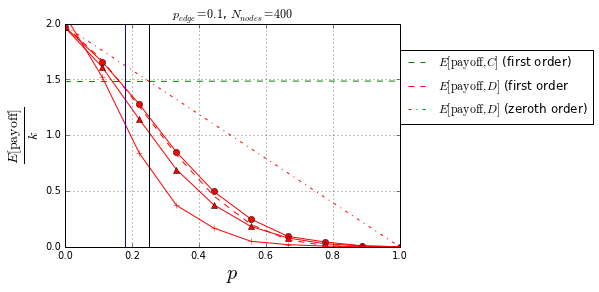

In [83]:
p_know_range = 1-(1-p_range)*(1-p_range**2)**(p_edge**2*N_nodes)
k = N_nodes*p_edge

plot(k_range,def_score_range/k,'-or',label='Sim. $E[\mathrm{payoff}|D]$ (first order, Erdos-Renyi)')
plot(k_range,def_score_range_sw/k,'-^r',label='Sim. $E[\mathrm{payoff}|D]$ (first order, Small World)')
plot(k_range,def_score_range_sf/k,'-sr',label='Sim. $E[\mathrm{payoff}|D]$ (first order, Scale Free)')

plot(k_range,expected_return_d(b,c,p_coop,p_edge_range,N_nodes,p_know_range)/k,'--r',label=r'Th. $E[\mathrm{payoff}|D]$ (first order)')
plot(k_range,expected_return_d(b,c,p_coop,p_edge_range,N_nodes,p_range)/k,'-.r',label=r'Th. $E[\mathrm{payoff}|D]$ (zeroth order)')
plot(k_range,expected_return_c(b,c,p_coop,p_edge_range,N_nodes,p_know_range)/k,'--g',label=r'Th. $E[\mathrm{payoff}|C]$')xlabel(r'$p$',size=20)
ylabel(r'$\frac{E[\mathrm{payoff}]}{k}$',size=20)
grid()
axvline(1/(1 + p_coop*(b-c)/c),color='k')
axvline(0.18)
legend(loc = (1,0.55))
ylim([0,b])
title(r'$p_{edge} = ' + str(p_edge) + '$, $N_{nodes} = ' + str(N_nodes) + '$')

Above we plot again the payoffs for cooperators and defectors in the limit of sparse defectors. The lines have the same meansing as in the previous section. The defector score will approach the Nash equilibrium situation where a single defector plays against all cooperators, while the cooperator score will aproach the all-$C$ situation. We plot a vertical blue line at the lowest value of $p$ satisfying the theoretical Nash equilibrium condition $\frac{c}{b} = p_{know}$ where we take $p_{known}(e,G) \approx 1 - (1-p)(1-p^2)^{p_{edge}^2N_{nodes}}$. For clarity we plot this function in the lower figure, together with a cross at the values for which $p_{know}(p) = b/c = 0.25$. The lower figure shows clearly, as one would expect, that gossip strictly improves $p_{know}$. We also plot a vertical black line giving the theoretical Nash equilibrium condition for the case without gossip: $\frac{c}{b} = p_{know} = p$

In the upper figure we find that the theoretical prediction accurately fits the simulation results. The payoffs cross close to where the blue line predicts for the Erdos-Renyi random graph. Overall the results with gossip show a lower threshold for $p$ than for direct reciprocity (black line, "zeroth order gossip"). Gossip makes it easier to stabilize cooperation. Moreover, we find again that social-network graphs have an even stronger effect. The Nash equilibrium condition is less stringent on $p$ using these graphs. This means that gossip and common social network structures both stabilize cooperative strategies significantly. 

# More connections, more cooperation

Let us now examine the effect of the number of neighbors on the relative payoffs. We can use the same procedure as earlier, but vary $p_{edge}$ this time.
Using the condition $\frac{c}{b} < p_{know} \approx 1 - (1-p)(1-p^2)^{p_{edge}^2N_{nodes}}$, we can solve for $p_{edge}$ and obtain
$$p_{edge} \gt \sqrt{\frac{1}{N}  \left(\frac{log(1 - \frac{c}{b}) - log(1 - p)}{log(1 - p^2)}\right)}$$

In [31]:
p_trial_range = array([0.05,0.2,0.6])
close('all')
for j,p in enumerate(p_trial_range):
    num_trials_default = 5
    N_nodes = 1000
    p_coop = 1 - 1.0/N_nodes
    p_edge_range = array([0.1,0.25,0.5,1,2,3,4])*sqrt(5.0/N_nodes)#array([0.1,0.25,0.5,1,2,3,4])*sqrt(5.0/N_nodes)
    num_trials_array = num_trials_default*ones_like(p_edge_range)
    # num_trials_array[0:3] *= 5
    # num_trials_array[0:1] *= 5
    p_know_range_th = get_p_known_first_order(p_edge_range**2*N_nodes,p)
    p_know_range = zeros_like(p_edge_range)
    p_know_range_sw = zeros_like(p_edge_range)
    p_know_range_sf = zeros_like(p_edge_range)
    mutual_neighbors_range = zeros_like(p_edge_range)
    mutual_neighbors_range_sw = zeros_like(p_edge_range)
    mutual_neighbors_range_sf = zeros_like(p_edge_range)
    num_edges_range = zeros_like(p_edge_range)
    num_edges_range_sw = zeros_like(p_edge_range)
    num_edges_range_sf = zeros_like(p_edge_range)



    for i,p_edge in enumerate(p_edge_range):
        num_trials = int(round(num_trials_array[i]))
        p_know_range[i],mutual_neighbors_range[i],num_edges_range[i] = get_average_mutual_neighbors_for_graph_type(N_nodes,p_edge,p,num_trials,create_graph,random_number=False)
        p_know_range_sw[i],mutual_neighbors_range_sw[i],num_edges_range_sw[i] = get_average_mutual_neighbors_for_graph_type(N_nodes,p_edge,p,num_trials,create_small_world_graph,random_number=False)
        p_know_range_sf[i],mutual_neighbors_range_sf[i],num_edges_range_sf[i] = get_average_mutual_neighbors_for_graph_type(N_nodes,p_edge,p,num_trials,create_scale_free_graph,random_number=False)

    k_range_th = N_nodes*p_edge_range
    
    #plotting
    figure()
    k_range = 2.0*num_edges_range/N_nodes
    k_range_sw = 2.0*num_edges_range_sw/N_nodes
    k_range_sf = 2.0*num_edges_range_sf/N_nodes

    # plot(k_range,def_score_range,'-or',label='Sim. $E[\mathrm{payoff}|D]$ (first order, Erdos-Renyi)')
    # plot(k_range,def_score_range_sw,'-^r',label='Sim. $E[\mathrm{payoff}|D]$ (first order, Small World)')
    # plot(k_range,def_score_range_sf,'-sr',label='Sim. $E[\mathrm{payoff}|D]$ (first order, Scale Free)')
    # plot(k_range,expected_return_d(b,c,p_coop,p_edge_range,N_nodes,p_know_range_th)/k_range,'--r',label=r'Th. $E[\mathrm{payoff}|D]$ (first order)')
    # plot(k_range,expected_return_d(b,c,p_coop,p_edge_range,N_nodes,p)/k_range,'-.r',label=r'Th. $E[\mathrm{payoff}|D]$ (zeroth order)')
    # plot(k_range,expected_return_c(b,c,p_coop,p_edge_range,N_nodes,p_know_range_th)/k_range,'--g',label=r'Th. $E[\mathrm{payoff}|C]$')

    # plot(k_range,expected_return_d(b,c,p_coop,p_edge_range,N_nodes,p_know_range)/k_range,'--k',label=r'Th. $E[\mathrm{payoff}|D]$ (first order)')
    # plot(k_range,expected_return_d(b,c,p_coop,p_edge_range,N_nodes,get_p_known_first_order(mutual_neighbors_range,p))/k_range,'--b',label=r'Th. $E[\mathrm{payoff}|D]$ (first order)')

    # plot(k_range,expected_return_d(b,c,p_coop,p_edge_range,N_nodes,p_know_range_sw)/k_range,'--k',label=r'Th. $E[\mathrm{payoff}|D]$ (first order)')
    # plot(k_range,expected_return_d(b,c,p_coop,p_edge_range,N_nodes,get_p_known_first_order(mutual_neighbors_range_sw,p))/k_range,'--b',label=r'Th. $E[\mathrm{payoff}|D]$ (first order)')


    # plot(k_range,expected_return_d(b,c,p_coop,p_edge_range,N_nodes,p_know_range_sf)/k_range,'--k',label=r'Th. $E[\mathrm{payoff}|D]$ (first order)')
    # plot(k_range,expected_return_d(b,c,p_coop,p_edge_range,N_nodes,get_p_known_first_order(mutual_neighbors_range_sf,p))/k_range,'--b',label=r'Th. $E[\mathrm{payoff}|D]$ (first order)')
    axhline(1/p,color = 'k',label=r'Th. $\left(b/c\right)_{critical}$ (zeroth order)')

    plot(k_range_th,1/p_know_range_th,'--k',label=r'Th. $\left(b/c\right)_{critical}$ (first order)')

    plot(k_range,1/p_know_range,'-ob',label=r'Sim. $\left(b/c\right)_{critical}$ (first order, Erdos-Renyi)')
    plot(k_range_sw,1/p_know_range_sw,'-^r',label=r'Sim. $\left(b/c\right)_{critical}$ (first order, Small World)')
    plot(k_range_sf,1/p_know_range_sf,'-sg',label=r'Sim. $\left(b/c\right)_{critical}$ (first order, Clustered Scale Free)')

    #plot as a function of mutual neighbors:
    # plot(k_range_th**2/N_nodes,1/p_know_range_th,'--r',label=r'Th. $\left(b/c\right)_{critical}$ (first order)')

    # plot(mutual_neighbors_range,1/p_know_range,'-ob',label=r'Sim. $\left(b/c\right)_{critical}$ (first order, Erdos-Renyi)')
    # plot(mutual_neighbors_range_sw,1/p_know_range_sw,'-^b',label=r'Sim. $\left(b/c\right)_{critical}$ (first order, Small World)')
    # plot(mutual_neighbors_range_sf,1/p_know_range_sf,'-sb',label=r'Sim. $\left(b/c\right)_{critical}$ (first order, Scale Free)')



    #plot with mutual neighbors
    # plot(k_range,1/get_p_known_first_order(mutual_neighbors_range,p),'--or',label=r'Sim. $\left(b/c\right)_{critical}$ (first order, Erdos-Renyi)')
    # plot(k_range_sw,1/get_p_known_first_order(mutual_neighbors_range_sw,p),'--^r',label=r'Sim. $\left(b/c\right)_{critical}$ (first order, Small World)')
    # plot(k_range_sf,1/get_p_known_first_order(mutual_neighbors_range_sf,p),'--sr',label=r'Sim. $\left(b/c\right)_{critical}$ (first order, Scale Free)')


    xlabel(r'$k = N_{nodes} p_{edge}$',size=20)
    ylabel(r'$\left(\frac{b}{c}\right)_{critical}$',size=20)
    grid()
    #axhline(N_nodes*sqrt(1.0/N_nodes*(log(1-1.0*c/b) - log(1- p))/log(1-p**2)))
    if j == len(p_trial_range)-1:
        legend(loc = (1.02,0.63))
    title(r'$p = ' + str(p) + '$, $N_{nodes} = ' + str(N_nodes) + '$',size=20)
    ylim(1,1.1/p)
    #savefig('b_c_critical_vs_k_p' +  str(p) + '.png',bbox_inches='tight')

1000 3523
1000 3519
no neighbors
1000 3452
no neighbors
1000 3491
1000 3497
1000 3000
1000 3000
1000 3000
1000 3000
1000 3000
1000 2990
1000 2990
1000 2991
1000 2991
1000 2991
1000 8734
1000 8901
1000 8671
1000 8905
1000 8732
1000 8000
1000 8000
1000 8000
1000 8000
1000 8000
1000 7934
1000 7934
1000 7930
1000 7934
1000 7933
1000 17811
1000 17730
1000 17599
1000 17829
1000 17634
1000 17000
1000 17000
1000 17000
1000 17000
1000 17000
1000 16710
1000 16711
1000 16711
1000 16711
1000 16710
1000 35408
1000 35313
1000 35405
1000 35344
1000 35331
1000 35000
1000 35000
1000 35000
1000 35000
1000 35000
1000 33775
1000 33775
1000 33774
1000 33775
1000 33772
1000 70410
1000 70741
1000 70607
1000 70703
1000 70867
1000 70000
1000 70000
1000 70000
1000 70000
1000 70000
1000 65081
1000 65092
1000 65093
1000 65095
1000 65085
1000 106005
1000 106422
1000 105757
1000 106324
1000 105515
1000 106000
1000 106000
1000 106000
1000 106000
1000 106000
1000 94759
1000 94762
1000 94758
1000 94759
1000 94762
1000

In [68]:
close()
k_range = 2.0*num_edges_range/N_nodes
k_range_sw = 2.0*num_edges_range_sw/N_nodes
k_range_sf = 2.0*num_edges_range_sf/N_nodes

# plot(k_range,def_score_range,'-or',label='Sim. $E[\mathrm{payoff}|D]$ (first order, Erdos-Renyi)')
# plot(k_range,def_score_range_sw,'-^r',label='Sim. $E[\mathrm{payoff}|D]$ (first order, Small World)')
# plot(k_range,def_score_range_sf,'-sr',label='Sim. $E[\mathrm{payoff}|D]$ (first order, Scale Free)')
# plot(k_range,expected_return_d(b,c,p_coop,p_edge_range,N_nodes,p_know_range_th)/k_range,'--r',label=r'Th. $E[\mathrm{payoff}|D]$ (first order)')
# plot(k_range,expected_return_d(b,c,p_coop,p_edge_range,N_nodes,p)/k_range,'-.r',label=r'Th. $E[\mathrm{payoff}|D]$ (zeroth order)')
# plot(k_range,expected_return_c(b,c,p_coop,p_edge_range,N_nodes,p_know_range_th)/k_range,'--g',label=r'Th. $E[\mathrm{payoff}|C]$')

# plot(k_range,expected_return_d(b,c,p_coop,p_edge_range,N_nodes,p_know_range)/k_range,'--k',label=r'Th. $E[\mathrm{payoff}|D]$ (first order)')
# plot(k_range,expected_return_d(b,c,p_coop,p_edge_range,N_nodes,get_p_known_first_order(mutual_neighbors_range,p))/k_range,'--b',label=r'Th. $E[\mathrm{payoff}|D]$ (first order)')

# plot(k_range,expected_return_d(b,c,p_coop,p_edge_range,N_nodes,p_know_range_sw)/k_range,'--k',label=r'Th. $E[\mathrm{payoff}|D]$ (first order)')
# plot(k_range,expected_return_d(b,c,p_coop,p_edge_range,N_nodes,get_p_known_first_order(mutual_neighbors_range_sw,p))/k_range,'--b',label=r'Th. $E[\mathrm{payoff}|D]$ (first order)')


# plot(k_range,expected_return_d(b,c,p_coop,p_edge_range,N_nodes,p_know_range_sf)/k_range,'--k',label=r'Th. $E[\mathrm{payoff}|D]$ (first order)')
# plot(k_range,expected_return_d(b,c,p_coop,p_edge_range,N_nodes,get_p_known_first_order(mutual_neighbors_range_sf,p))/k_range,'--b',label=r'Th. $E[\mathrm{payoff}|D]$ (first order)')
axhline(1/p,color = 'k',label=r'Th. $\left(b/c\right)_{critical}$ (zeroth order)')

plot(k_range_th,1/p_know_range_th,'--k',label=r'Th. $\left(b/c\right)_{critical}$ (first order)')

plot(k_range,1/p_know_range,'-ob',label=r'Sim. $\left(b/c\right)_{critical}$ (first order, Erdos-Renyi)')
plot(k_range_sw,1/p_know_range_sw,'-^r',label=r'Sim. $\left(b/c\right)_{critical}$ (first order, Small World)')
plot(k_range_sf,1/p_know_range_sf,'-sg',label=r'Sim. $\left(b/c\right)_{critical}$ (first order, Clustered Scale Free)')

#plot as a function of mutual neighbors:
# plot(k_range_th**2/N_nodes,1/p_know_range_th,'--r',label=r'Th. $\left(b/c\right)_{critical}$ (first order)')

# plot(mutual_neighbors_range,1/p_know_range,'-ob',label=r'Sim. $\left(b/c\right)_{critical}$ (first order, Erdos-Renyi)')
# plot(mutual_neighbors_range_sw,1/p_know_range_sw,'-^b',label=r'Sim. $\left(b/c\right)_{critical}$ (first order, Small World)')
# plot(mutual_neighbors_range_sf,1/p_know_range_sf,'-sb',label=r'Sim. $\left(b/c\right)_{critical}$ (first order, Scale Free)')



#plot with mutual neighbors
# plot(k_range,1/get_p_known_first_order(mutual_neighbors_range,p),'--or',label=r'Sim. $\left(b/c\right)_{critical}$ (first order, Erdos-Renyi)')
# plot(k_range_sw,1/get_p_known_first_order(mutual_neighbors_range_sw,p),'--^r',label=r'Sim. $\left(b/c\right)_{critical}$ (first order, Small World)')
# plot(k_range_sf,1/get_p_known_first_order(mutual_neighbors_range_sf,p),'--sr',label=r'Sim. $\left(b/c\right)_{critical}$ (first order, Scale Free)')


xlabel(r'$k = N_{nodes} p_{edge}$',size=20)
ylabel(r'$\left(\frac{b}{c}\right)_{critical}$',size=20)
grid()
#axhline(N_nodes*sqrt(1.0/N_nodes*(log(1-1.0*c/b) - log(1- p))/log(1-p**2)))
legend(loc=(0.25,0.32))#legend(loc = (1.02,0.63))
title(r'$p = ' + str(p) + '$, $N_{nodes} = ' + str(N_nodes) + '$',size=20)
ylim(1,1.1/p)
#savefig('b_c_critical_vs_k_p0.6_shifted_legend.png',bbox_inches='tight')

The lines in the plot have the same meaning as in the earlier plots. However, everything is plotted as a function of $p_{edge}$ this time. For the zeroth-order case, the payoff both depends linearly on the number of neighbors and thus on $p_{edge}$. Since we chose $p = 0.2 = p_{know} < \frac{c}{b}$, defectors will always be favored here. However, for the first-order case, gossip gets more efficient  with increasing $p_{edge}$ ($p_{know}$ rises, as illustrated in the lower figure). Therefore, as we increase the number of neighbors for a given graph, the payoffs for cooperators rise and those for defectors fall (relative to the naive linear dependence on $n_{neighbors}$). Again, the theoretical prediction for the Nash equilibrium condition is plotted in blue and agrees well with the simulation results. With sufficient connectivity, cooperation becomes stable, and the effect is more pronounced for the social network like graphs. The key insight is that with gossip, additional neighbors and connections in the network stabilize cooperation, while this is not the case for direct reciprocity without gossip.

# Future Work

We have presented a work in progress. In the following, we outline several of the possible next steps.

- It will be important to improve upon the analytical work regarding the expectations for the payoff. We have made some quite crude approximations and it will be important to either find better approximations or justify the level of accuracy of the approximations that we have made.
- In order to try our results on social-network graphs, we have employed some external graph generators that are known to represent social network structures well. However, there are several other graph types (like regular lattices, other small world networks, trees, etc.) that we have yet to try out.
- We have only used the lowest order approximation to the flow of gossip (i.e. across nearest neighbors). In reality, gossip can be transmitted (albeit strongly suppressed) across an arbitrary degree. While higher order in the approximation (i.e. using gossip paths of length $2$ or longer) should not qualitatively affect the results, it will be insightful to consider the effect of allowing more complex flow of information. There will likely be some percolation limit to which the increasingly higher order approximations will converge.
- So far, we have only dealt with the static situation of a single round in the game and the resulting payoffs. A next step will be to extend this to evolutionary game dynamics and study the effect of gossip on the evolution of cooperation in that context.
- Finally, we might reverse the question about causality. We have found that certain graph structures (e.g. tightly knit and highly clustered graphs) stabilize cooperation through gossip very efficiently. We might consider a model where the graph structure is dependent on the underlying strategy set of the nodes and see whether cooperation-favoring structures emerge and evolve naturally.

# Acknowledgements

We thank Prof. Martin Nowak for guidance and helpful discussions, as well as Ben Adlam for his support.

In [31]:
int(round(29.51))

30

Abstract: background of study. First few references. Begin with general introduction, most of the references from there.

References: indirect reciprocity, spatial games, direct reciprocity.
$b/c > k$ is for unconditional cooperators and spatial selection, not 

Background, more references after the abstract.

Only few display equations, a few inline.

Add an appendix in which the

Should p and p^2 be separate parameters:
$$1 - (1-p)(1- p q)^n$$

$P(e,G) = P_{ij}(n_{ij})$

$N = N_{nodes}$
$q = p$
$p = p_{edge}$
$(b/c)* = (b/c)_{critical}$
In the figures
Average degree, $k$
Title, just $p$, put $N$ in the legend.

Nature selling points:
- single parameter model
    - captures all the issues of complexity and strategy in the simple concept of "correctness"
- more connectivity is better
- real results are strictly better
    - more social graphs than prediction
    - more gossip than prediction
- b/c > k for unconditional cooperators. What about highly connected populations? Gossip can support the evolution of cooperation. We might want to show how much gossip can change the b/c > k rule.
- Show our predictions for different graphs as a function of the clustering coefficient
- Simple prediction $b/c > 1/P$